In [1]:
# Python imports
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

# 0. Constants

In [2]:
# Hyper-parameters.
LEARNING_RATE = 0.01
EPOCHS = 1000
BATCH_SIZE = 100
LAYER_SIZE = 84

# Others.
WIDTH, HEIGHT = 28, 28
CATEGORIES = 10
SAVED_FILENAME = 'MNIST-FCN-1-activation'
VARIANTS = ['No Activation', 'Sigmoid', 'ReLU']

# 1. Dataset

I use MNIST as the dataset.

* Image width is 28.
* Image height is 28.
* Image channel is 1.
* Value of each pixel is in [0, 1].

Load training and test datasets.

In [3]:
# image, label = dataset_training[i]
# image, label = dataset_training[i]
# image is a tensor of shape (1, WIDTH, HEIGHT).
# label is a Python int number.
dataset_training = utils.MNIST('./data', train=True, transform=torchvision.transforms.ToTensor())
dataset_test = utils.MNIST('./data', train=False, transform=torchvision.transforms.ToTensor())

Create data loaders for training and test.

In [4]:
# samples = next(iter(dataloader_training))
# samples = next(iter(dataloader_test))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, 1, WIDTH, HEIGHT)
# samples[1] is a tensor of shape (BATCH_SIZE,)
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

Inspect number of samples in both datasets.

In [5]:
headers = ['Dataset', 'Number of Samples']
rows = [
    ['Training', len(dataset_training)],
    ['Test', len(dataset_test)],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Dataset   |   Number of Samples |
|-----------|---------------------|
| Training  |               60000 |
| Test      |               10000 |


Sample images of all labels.

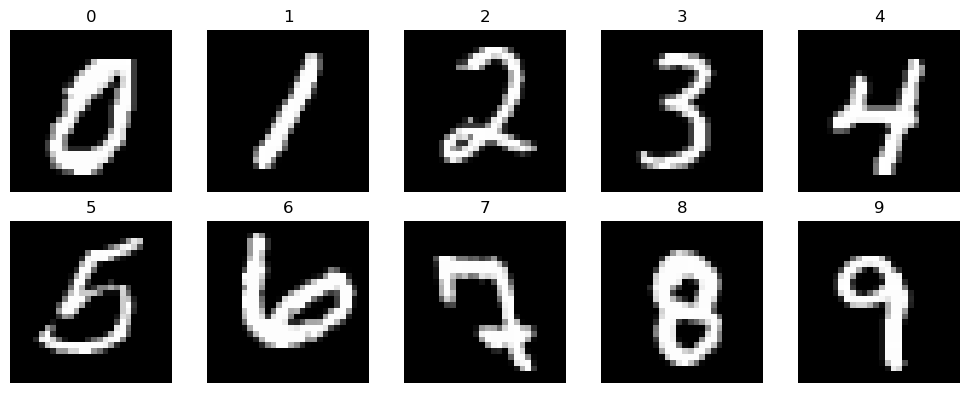

In [6]:
# Sample 10 images with labels 0 to 9.
samples = utils.sample_MNIST_with_all_labels(dataset_training)

# Plot the images.
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(10, 4))
for row in range(rows):
    for col in range(cols):
        axs[row, col].imshow(samples[row*cols+col].squeeze(), cmap=plt.cm.gray)
        axs[row, col].axis('off')
        axs[row, col].set_title(row*cols+col)
plt.tight_layout()

# 2. Model

In [7]:
models = [
    torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(WIDTH*HEIGHT, LAYER_SIZE),
        torch.nn.Linear(LAYER_SIZE, CATEGORIES),
        torch.nn.Softmax(dim=1)
    ),
    torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(WIDTH*HEIGHT, LAYER_SIZE),
        torch.nn.Sigmoid(),
        torch.nn.Linear(LAYER_SIZE, CATEGORIES),
        torch.nn.Softmax(dim=1)
    ),
    torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(WIDTH*HEIGHT, LAYER_SIZE),
        torch.nn.ReLU(),
        torch.nn.Linear(LAYER_SIZE, CATEGORIES),
        torch.nn.Softmax(dim=1)
    ),
]

for i in range(len(VARIANTS)):
    print(f'Structure of model {VARIANTS[i]} is')
    print(models[i])

Structure of model No Activation is
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=84, bias=True)
  (2): Linear(in_features=84, out_features=10, bias=True)
  (3): Softmax(dim=1)
)
Structure of model Sigmoid is
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=84, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=84, out_features=10, bias=True)
  (4): Softmax(dim=1)
)
Structure of model ReLU is
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=84, bias=True)
  (2): ReLU()
  (3): Linear(in_features=84, out_features=10, bias=True)
  (4): Softmax(dim=1)
)


Inspect the number of parameters.

In [8]:
nums_parameters = []
for i in range(len(VARIANTS)):
    num_parameters = 0
    for params in models[i].parameters():
        num_parameters_temp = 1
        size = params.size()
        for dim_size in size:
            num_parameters_temp *= dim_size
        num_parameters += num_parameters_temp
    nums_parameters.append(num_parameters)

headers = ['Variant', 'Number of Parameters']

rows = []
for i in range(len(VARIANTS)):
    rows.append([VARIANTS[i], nums_parameters[i]])

print(tabulate(rows, headers=headers, tablefmt='github'))

| Variant       |   Number of Parameters |
|---------------|------------------------|
| No Activation |                  66790 |
| Sigmoid       |                  66790 |
| ReLU          |                  66790 |


# 3. Training

Define a function to load from saved data.

In [9]:
def load(models):
    
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Construct structs losses, accuracies, losses_test and accuracies_test for returning.
    losses, accuracies, losses_test, accuracies_test, training_times = [], [], [], [], []

    # Resume model from saved data.
    for i in range(len(models)):
        state_dict = data[i]['state_dict']
        models[i].load_state_dict(state_dict)
        losses.append(data[i]['losses'])
        accuracies.append(data[i]['accuracies'])
        losses_test.append(data[i]['losses_test'])
        accuracies_test.append(data[i]['accuracies_test'])
        training_times.append(data[i]['training_time'])

    # Return losses and accuracies for training and testing.
    return losses, accuracies, losses_test, accuracies_test, training_times

Define a function to save data.

In [10]:
def save(models, losses, accuracies, losses_test, accuracies_test, training_times):

    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = []
    for i in range(len(models)):
        data.append({
            'state_dict': models[i].state_dict(),
            'losses': losses[i],
            'accuracies': accuracies[i],
            'losses_test': losses_test[i],
            'accuracies_test': accuracies_test[i],
            'training_time': training_times[i],
        })

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

Define a function to calculate loss and statistics on a dataset.

In [11]:
def calculateStatistics(dataloader, model, loss_fn):
    
    with torch.no_grad():
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)
        loss, correct = 0, 0

        for images, labels in dataloader:
            # Make predictions.
            preds = model(images)

            # Calculate the loss.
            loss += loss_fn(preds, labels).item()

            # Calculate the number of correctnesses.
            correct += (preds.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

        # Calculate the mean loss and correct.
        loss /= num_batches
        accuracy = correct / num_samples

    return loss, accuracy

Define a function to train the model for one epoch.

In [12]:
def trainOneEpoch(model, dataloader_training, dataloader_test, loss_fn, optimizer, learning_rate):

    # Constants.
    BATCHES = len(dataloader_training)
    SAMPLES = len(dataloader_training.dataset)

    # Variables.
    loss_total, correct_total = 0, 0

    for batch, [images, labels] in enumerate(dataloader_training):
        # Make predictions.
        pred = model(images)

        # Calculate the loss.
        loss = loss_fn(pred, labels)
        loss_total += loss.item()

        # Calculate the number of correctness.
        correct_total += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

        # Back propagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Calculate the mean loss across all batches.
    loss = loss_total / BATCHES

    # Calculate the accuracy across all batches.
    accuracy = correct_total / SAMPLES

    # Calculate loss and correct for test.
    loss_test, accuracy_test = calculateStatistics(dataloader_test, model, loss_fn)

    return loss, accuracy, loss_test, accuracy_test

Define a function to train the model for all epochs.

In [13]:
def train(model, dataloader_training, dataloader_test, learning_rate, epochs, print_epoch=True):
    
    # Define the loss function and optimizer.
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE)

    # Define losses and corrects for training and test.
    losses, accuracies = [], []
    losses_test, accuracies_test = [], []

    # Define a timer and start timing.
    t = utils.Timer()
    t.start()

    # Calculate losses and corrects before training.
    loss, accuracy = calculateStatistics(dataloader_training, model, loss_fn)
    losses.append(loss)
    accuracies.append(accuracy)
    loss_test, accuracy_test = calculateStatistics(dataloader_test, model, loss_fn)
    losses_test.append(loss_test)
    accuracies_test.append(accuracy_test)

    # Print statistics.
    if print_epoch:
        print(f'Epoch #0: training loss ({loss:.3f}) | training accu ({accuracy:.3f}) | test loss ({loss_test:.3f}) | test accu ({accuracy_test:.3f})')

    # Run epochs.
    for epoch in range(epochs):

        # Train one epoch.
        loss, accuracy, loss_test, accuracy_test = trainOneEpoch(model, dataloader_training, dataloader_test, loss_fn, optimizer, learning_rate)

        # Record the loss and accuracy.
        losses.append(loss)
        accuracies.append(accuracy)
        losses_test.append(loss_test)
        accuracies_test.append(accuracy_test)

        # Print statistics.
        if print_epoch:
            print(f'Epoch #{epoch+1}: training loss ({loss:.3f}) | training accu ({accuracy:.3f}) | test loss ({loss_test:.3f}) | test accu ({accuracy_test:.3f})')

    # Stop timing.
    t.stop()

    # Return losses, accuracies and training time.
    return losses, accuracies, losses_test, accuracies_test, t.getDuration()


Actually train the models.

In [14]:
if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
    losses, accuracies, losses_test, accuracies_test, training_times = load(models)
else:
    losses, accuracies, losses_test, accuracies_test, training_times = [], [], [], [], []
    for i in range(len(VARIANTS)):
        print(f'Training model {VARIANTS[i]}...')
        losses_1_model, accuracies_1_model, losses_test_1_model, accuracies_test_1_model, training_time = train(models[i], dataloader_training, dataloader_test, LEARNING_RATE, EPOCHS, print_epoch=False)
        losses.append(losses_1_model)
        accuracies.append(accuracies_1_model)
        losses_test.append(losses_test_1_model)
        accuracies_test.append(accuracies_test_1_model)
        training_times.append(training_time)
    save(models, losses, accuracies, losses_test, accuracies_test, training_times)

Training model No Activation...
Training model Sigmoid...
Training model ReLU...


Show the training time.

In [15]:
headers = ['Variant', 'Training Time']
rows = []
for i in range(len(VARIANTS)):
    rows.append([VARIANTS[i], training_times[i]])

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Variant       |   Training Time |
|---------------|-----------------|
| No Activation |         608.58  |
| Sigmoid       |         646.392 |
| ReLU          |         874.887 |


Visualize the training process for the first 50 epochs.

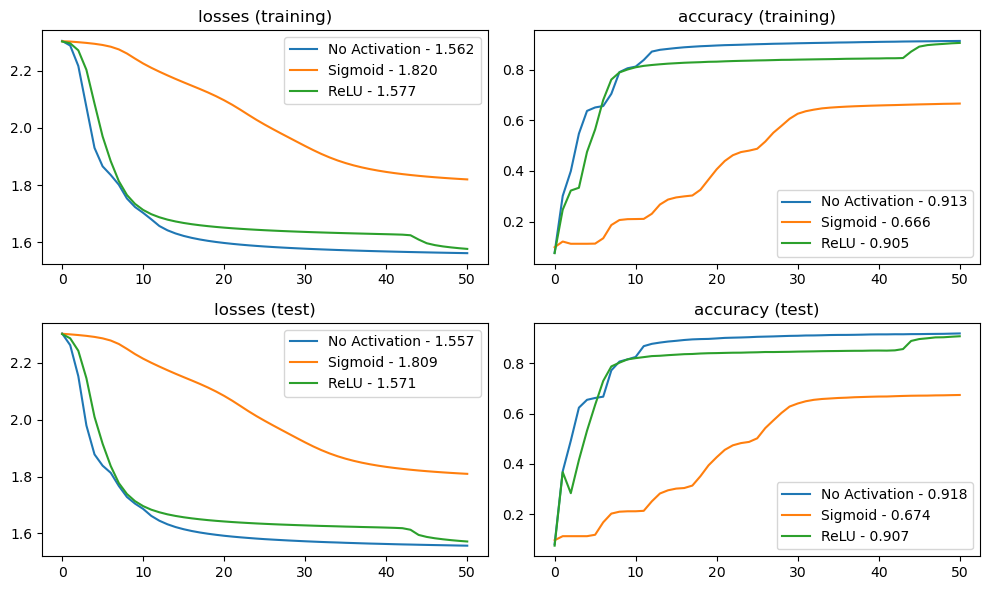

In [16]:
epoch_end = 50

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(10, 6))

for i in range(len(VARIANTS)):
    ax11.plot(losses[i][:epoch_end+1])
ax11.legend([f'{VARIANTS[i]} - {losses[i][epoch_end]:.3f}' for i in range(len(VARIANTS))], loc='best')
ax11.set_title(f'losses (training)')
for i in range(len(VARIANTS)):
    ax12.plot(accuracies[i][:epoch_end+1])
ax12.legend([f'{VARIANTS[i]} - {accuracies[i][epoch_end]:.3f}' for i in range(len(VARIANTS))], loc='best')
ax12.set_title(f'accuracy (training)')
for i in range(len(VARIANTS)):
    ax21.plot(losses_test[i][:epoch_end+1])
ax21.legend([f'{VARIANTS[i]} - {losses_test[i][epoch_end]:.3f}' for i in range(len(VARIANTS))], loc='best')
ax21.set_title(f'losses (test)')
for i in range(len(VARIANTS)):
    ax22.plot(accuracies_test[i][:epoch_end+1])
ax22.legend([f'{VARIANTS[i]} - {accuracies_test[i][epoch_end]:.3f}' for i in range(len(VARIANTS))], loc='best')
ax22.set_title(f'accuracy (test)')

plt.tight_layout()
plt.show()

Visualize the training process for all epochs.

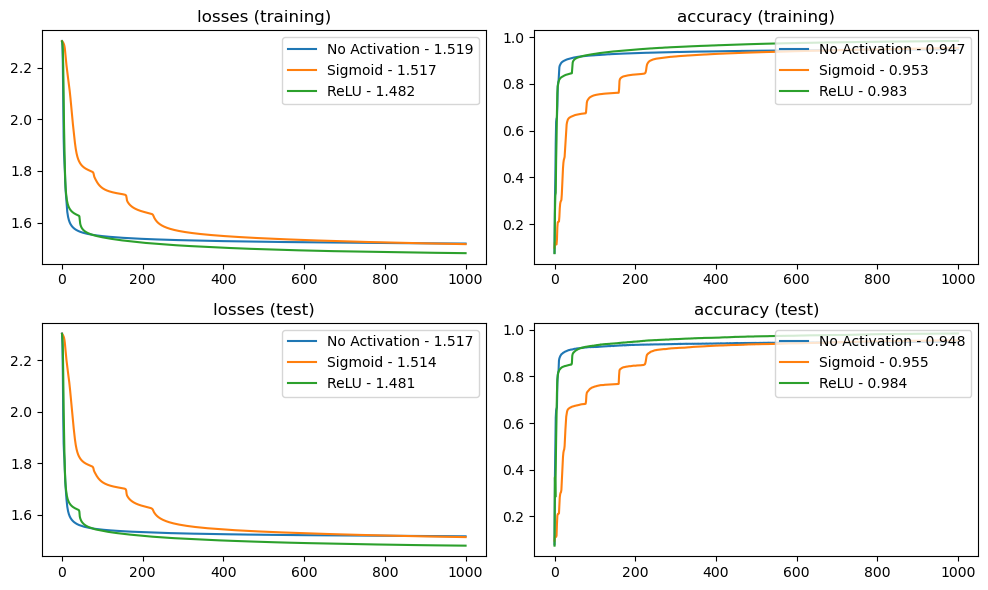

In [17]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(10, 6))

for i in range(len(VARIANTS)):
    ax11.plot(losses[i])
ax11.legend([f'{VARIANTS[i]} - {losses[i][EPOCHS]:.3f}' for i in range(len(VARIANTS))], loc='upper right')
ax11.set_title(f'losses (training)')
for i in range(len(VARIANTS)):
    ax12.plot(accuracies[i])
ax12.legend([f'{VARIANTS[i]} - {accuracies[i][EPOCHS]:.3f}' for i in range(len(VARIANTS))], loc='upper right')
ax12.set_title(f'accuracy (training)')
for i in range(len(VARIANTS)):
    ax21.plot(losses_test[i])
ax21.legend([f'{VARIANTS[i]} - {losses_test[i][EPOCHS]:.3f}' for i in range(len(VARIANTS))], loc='upper right')
ax21.set_title(f'losses (test)')
for i in range(len(VARIANTS)):
    ax22.plot(accuracies_test[i])
ax22.legend([f'{VARIANTS[i]} - {accuracies_test[i][EPOCHS]:.3f}' for i in range(len(VARIANTS))], loc='upper right')
ax22.set_title(f'accuracy (test)')

plt.tight_layout()
plt.show()